In [5]:
# Set up
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
# Encoding columns...
# Gender
train.loc[(train.Gender.isnull()) & (train.Married=='Yes'), "Gender"] = "Male"
train.loc[592,'Gender'] = 'Male'
train.loc[[507,588],'Gender'] = 'Male'

train.loc[(train.Gender == 'Male')|(train.Gender.isnull()), 'Gender'] = 0
train.loc[train.Gender == 'Female', 'Gender'] = 1
train.Gender = train.Gender.astype(float)

# Marriage Status
train.loc[[104,228],'Married'] = 'Yes'
train.loc[435, 'Married'] = 'No'

train.loc[train.Married == 'No', 'Married'] = 0
train.loc[(train.Married == 'Yes')|(train.Married.isnull()), 'Married'] = 1
train.Married = train.Married.astype(float)

# Dependents
train['has_child'] = 1
train.loc[(train.Dependents.isnull())|(train.Dependents=='0'),'has_child'] = 0
train.loc[train.Dependents.isnull(), 'Dependents'] = '0'

# Education
train.loc[train.Education=='Graduate', 'Education'] = 1
train.loc[train.Education=='Not Graduate', 'Education'] = 0
train.Education = train.Education.astype(int)

# Loan Status
train.loc[train.Loan_Status=='Y', 'Loan_Status'] = 1
train.loc[train.Loan_Status=='N', 'Loan_Status'] = 0
train.Loan_Status = train.Loan_Status.astype(int)

# Credit History
train.loc[(train.Loan_Status==1)&(train.Credit_History.isnull()), 'Credit_History'] = 1
train.loc[(train.Loan_Status==0)&(train.Credit_History.isnull()), 'Credit_History'] = 0
train.Credit_History = train.Credit_History.astype(int)

# Employment Type
train.loc[(train.Self_Employed == 'No')|(train.Self_Employed.isnull()), 'Self_Employed'] = 0
train.loc[train.Self_Employed == 'Yes', 'Self_Employed'] = 1
train.Self_Employed = train.Self_Employed.astype(float)

# Loan_Amount_Term
train.loc[train.Loan_Amount_Term.isnull(), 'Loan_Amount_Term'] = '360.0'

# Class, divided by ApplicantIncome
train['super_rich'] = train.ApplicantIncome>30000
train['rich'] = (train.ApplicantIncome>10000)&(train.ApplicantIncome<30000)
train['middle_class'] = (train.ApplicantIncome>4000)&(train.ApplicantIncome<10000)
train['poor'] = train.ApplicantIncome<30000

In [7]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
has_child             0
super_rich            0
rich                  0
middle_class          0
poor                  0
dtype: int64

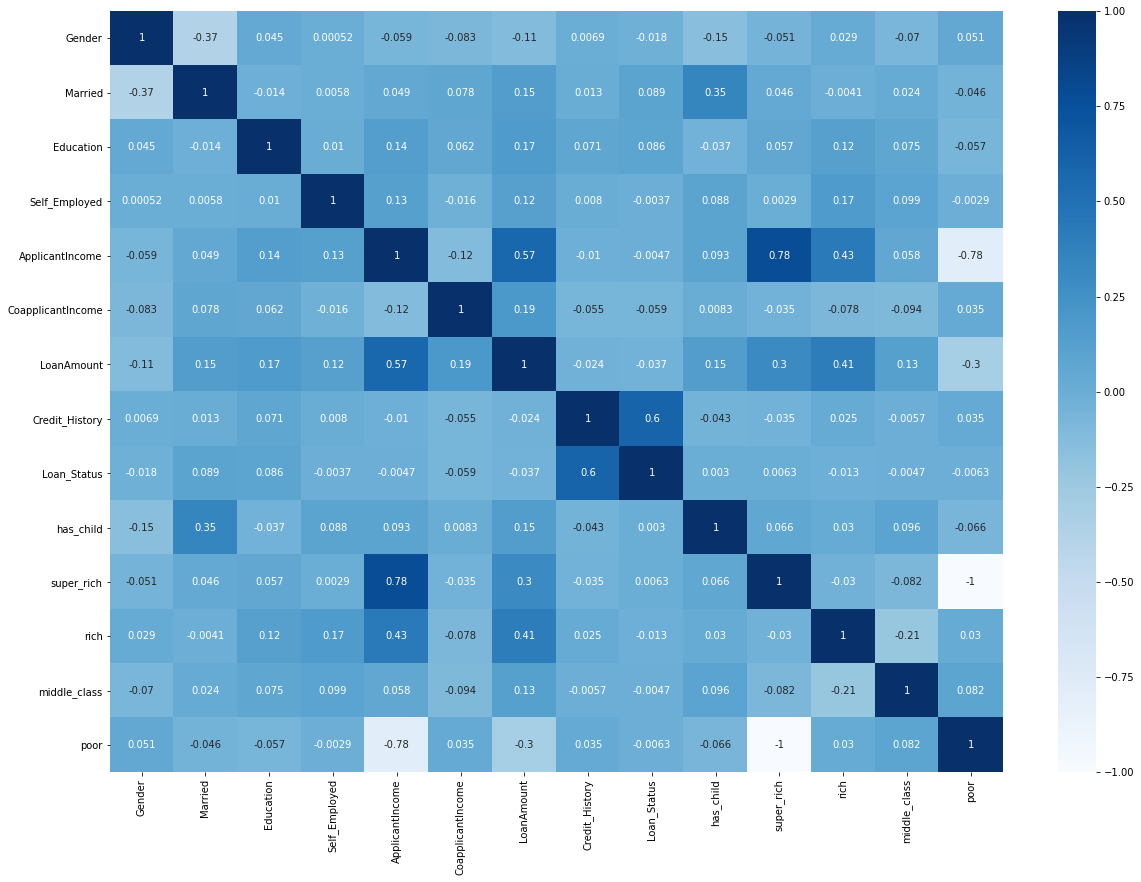

In [8]:
corr = train.corr()
plt.figure(figsize=(20,14))
sns.heatmap(corr, annot=True, cmap='Blues')

In [9]:
features = ['Married', 'Education', 'ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
label = ['Loan_Status']

test.loc[test.Married == 'No', 'Married'] = 0
test.loc[(test.Married == 'Yes'), 'Married'] = 1
test.Married = test.Married.astype(float)

test.loc[test.Education=='Graduate', 'Education'] = 1
test.loc[test.Education=='Not Graduate', 'Education'] = 0
test.Education = test.Education.astype(int)

In [10]:
from sklearn.impute import SimpleImputer

X_train = train[features]
y_train = train[label]
X_test = test[features]

# imputation
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(imputer.transform(X_test))

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

print(imputed_X_train.isnull().sum())
print('\n')
print(imputed_X_test.isnull().sum())
imputed_X_train.head()

Married             0
Education           0
ApplicantIncome     0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64


Married             0
Education           0
ApplicantIncome     0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64


,Married,Education,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.0,1.0,5849.0,146.412162,360.0,1.0
1,1.0,1.0,4583.0,128.000000,360.0,1.0
2,1.0,1.0,3000.0,66.000000,360.0,1.0
3,1.0,0.0,2583.0,120.000000,360.0,1.0
4,0.0,1.0,6000.0,141.000000,360.0,1.0


In [11]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

model = RandomForestRegressor(n_estimators = 10, random_state=77)
model.fit(imputed_X_train, np.ravel(y_train))
prediction = model.predict(imputed_X_test)
prediction

array([0.8, 1. , 0.9, 1. , 0.7, 0.8, 1. , 0. , 0.8, 1. , 0.9, 0.9, 1. ,
       0.4, 0.7, 1. , 0.9, 1. , 1. , 0.6, 0.8, 0.5, 0.9, 1. , 0.6, 0.3,
       1. , 0.5, 0.7, 0.8, 0.5, 1. , 0.9, 0.8, 1. , 0.1, 1. , 0.8, 1. ,
       0.9, 1. , 1. , 0.9, 0.7, 0.8, 0.8, 0.8, 1. , 0.8, 0.5, 0.9, 1. ,
       1. , 1. , 0.4, 0.3, 0.9, 1. , 0. , 0.7, 1. , 1. , 0.5, 0.1, 1. ,
       0.9, 0.1, 0.2, 1. , 0.1, 0.9, 0.2, 0.6, 1. , 0.3, 0.8, 1. , 0.8,
       0.7, 1. , 0.6, 0.7, 0. , 0.8, 0.3, 0.9, 0.5, 1. , 0.7, 0.3, 1. ,
       0.9, 0.7, 0.9, 0. , 0.8, 1. , 1. , 0.9, 0.9, 0.9, 0.3, 1. , 0.8,
       0.9, 1. , 0. , 1. , 1. , 0.9, 0.7, 0.7, 0.5, 1. , 1. , 0.6, 0.4,
       0. , 0. , 0. , 0.8, 1. , 0.1, 0.3, 0. , 0.7, 0. , 1. , 0.6, 0.4,
       1. , 0.7, 1. , 0.8, 0.6, 1. , 0.8, 0.6, 0.9, 0.9, 0.1, 0.9, 0. ,
       0.3, 0.5, 0.7, 0.9, 0. , 0.9, 0.8, 0.6, 1. , 0.8, 0.2, 0.9, 0.4,
       0.9, 0.8, 0.9, 0.7, 0.9, 0. , 1. , 0.9, 0.8, 0.4, 0. , 0.8, 0. ,
       0.6, 1. , 0.9, 1. , 0.1, 0.2, 1. , 1. , 0.6, 1. , 0.9, 1.

In [ ]:
submission = pd.read_csv("./data/sample_submission.csv", index_col='Loan_ID')
print(submission.shape)
submission.head()

In [ ]:
submission['Loan_Status'] = prediction
submission.loc[submission.Loan_Status==0,'Loan_Status'] = 'N'
submission.loc[submission.Loan_Status==1,'Loan_Status'] = 'Y'
submission.head()

In [ ]:
submission.to_csv("./2020.08.29_loan-prediction.csv")